<a href="https://www.kaggle.com/code/sharanharsoor/mlflow-end-to-end-ml-models?scriptVersionId=129006574" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction.<br>

MLflow is a powerful tool for managing the machine learning lifecycle. It enables tracking, packaging, and versioning of models, making it easier to reproduce and compare results. MLflow's model registry facilitates collaboration and deployment, ensuring consistent model serving across different environments. With its integration capabilities, MLflow works seamlessly with popular ML libraries and frameworks. It simplifies experiment tracking, allowing data scientists to log parameters, metrics, and output files for efficient model evaluation. In summary, MLflow streamlines the end-to-end process of developing, tracking, and deploying machine learning models, enhancing productivity, reproducibility, and collaboration in ML projects.

In this botebook we will learn about.

1.   Basic motivation of hyperparameter tuning
2.   MLflow UI using ngrok
3.   Installing MLFlow and basic use case
4.   Logging parameters, metrics with MLFlow
5.   Logging image artifacts with MLFlow
6.   Logging PyTorch models with MLFlow and loading them
<br>

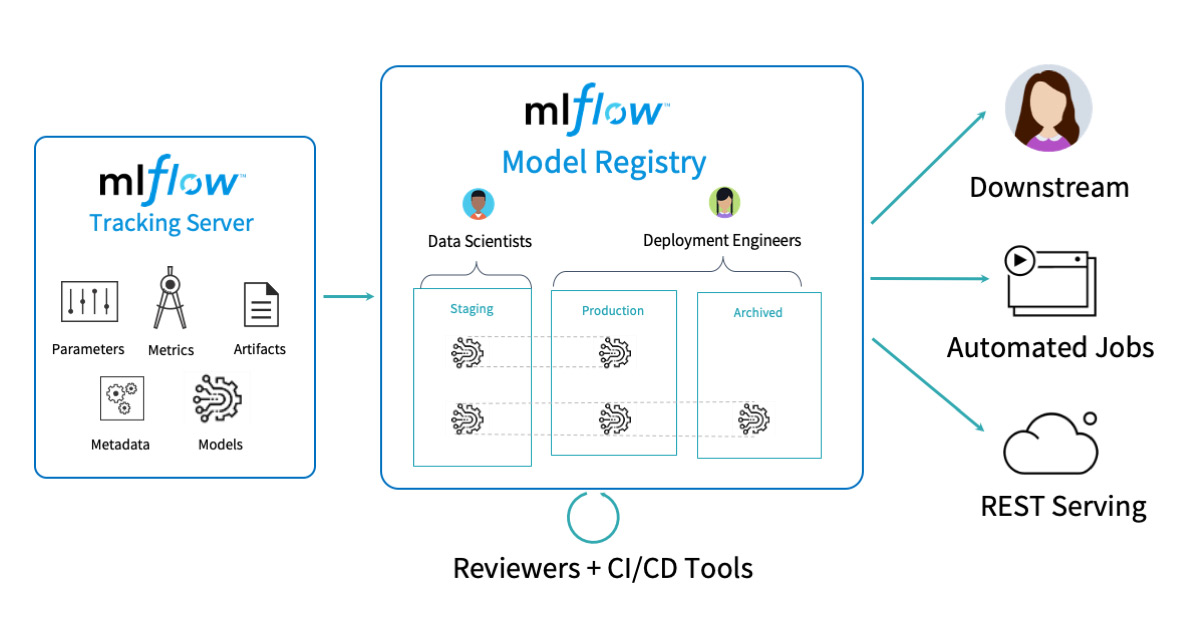

[image](https://www.databricks.com/blog/2020/04/15/databricks-extends-mlflow-model-registry-with-enterprise-features.html)

# Install and importing libs

In [1]:
# Install the requiered packages to run MLFlow

!pip install mlflow --quiet
!pip install pyngrok --quiet

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import mlflow
import mlflow.pytorch

In [4]:
get_ipython().system_raw("mlflow ui --port 5000 &")
mlflow.pytorch.autolog()

2023/05/10 09:08:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[2023-05-10 09:08:34 +0000] [88] [INFO] Starting gunicorn 20.1.0
[2023-05-10 09:08:34 +0000] [88] [INFO] Listening at: http://127.0.0.1:5000 (88)
[2023-05-10 09:08:34 +0000] [88] [INFO] Using worker: sync
[2023-05-10 09:08:34 +0000] [89] [INFO] Booting worker with pid: 89
[2023-05-10 09:08:34 +0000] [90] [INFO] Booting worker with pid: 90
[2023-05-10 09:08:34 +0000] [91] [INFO] Booting worker with pid: 91
[2023-05-10 09:08:34 +0000] [92] [INFO] Booting worker with pid: 92
/opt/conda/lib/python3.10/site-pack

# Setting up MLFLow UI

In [5]:
# IMP: please create a auth token from https://dashboard.ngrok.com/auth by creating an account. 
# the below auth ticket will not work for anyone re-running the notebook.
    
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2Padn9VzXvPy7nJXe6eAUTR3Dbd_6cXCwQeLNLwZDCWL5ypKs"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)


MLflow Tracking UI: https://8990-34-83-109-100.ngrok-free.app


The above MLflow url is the most important one for monitoring model works. <br> 
Check the mention of Artifact Location: file:///kaggle/working/mlruns/327332781967977011

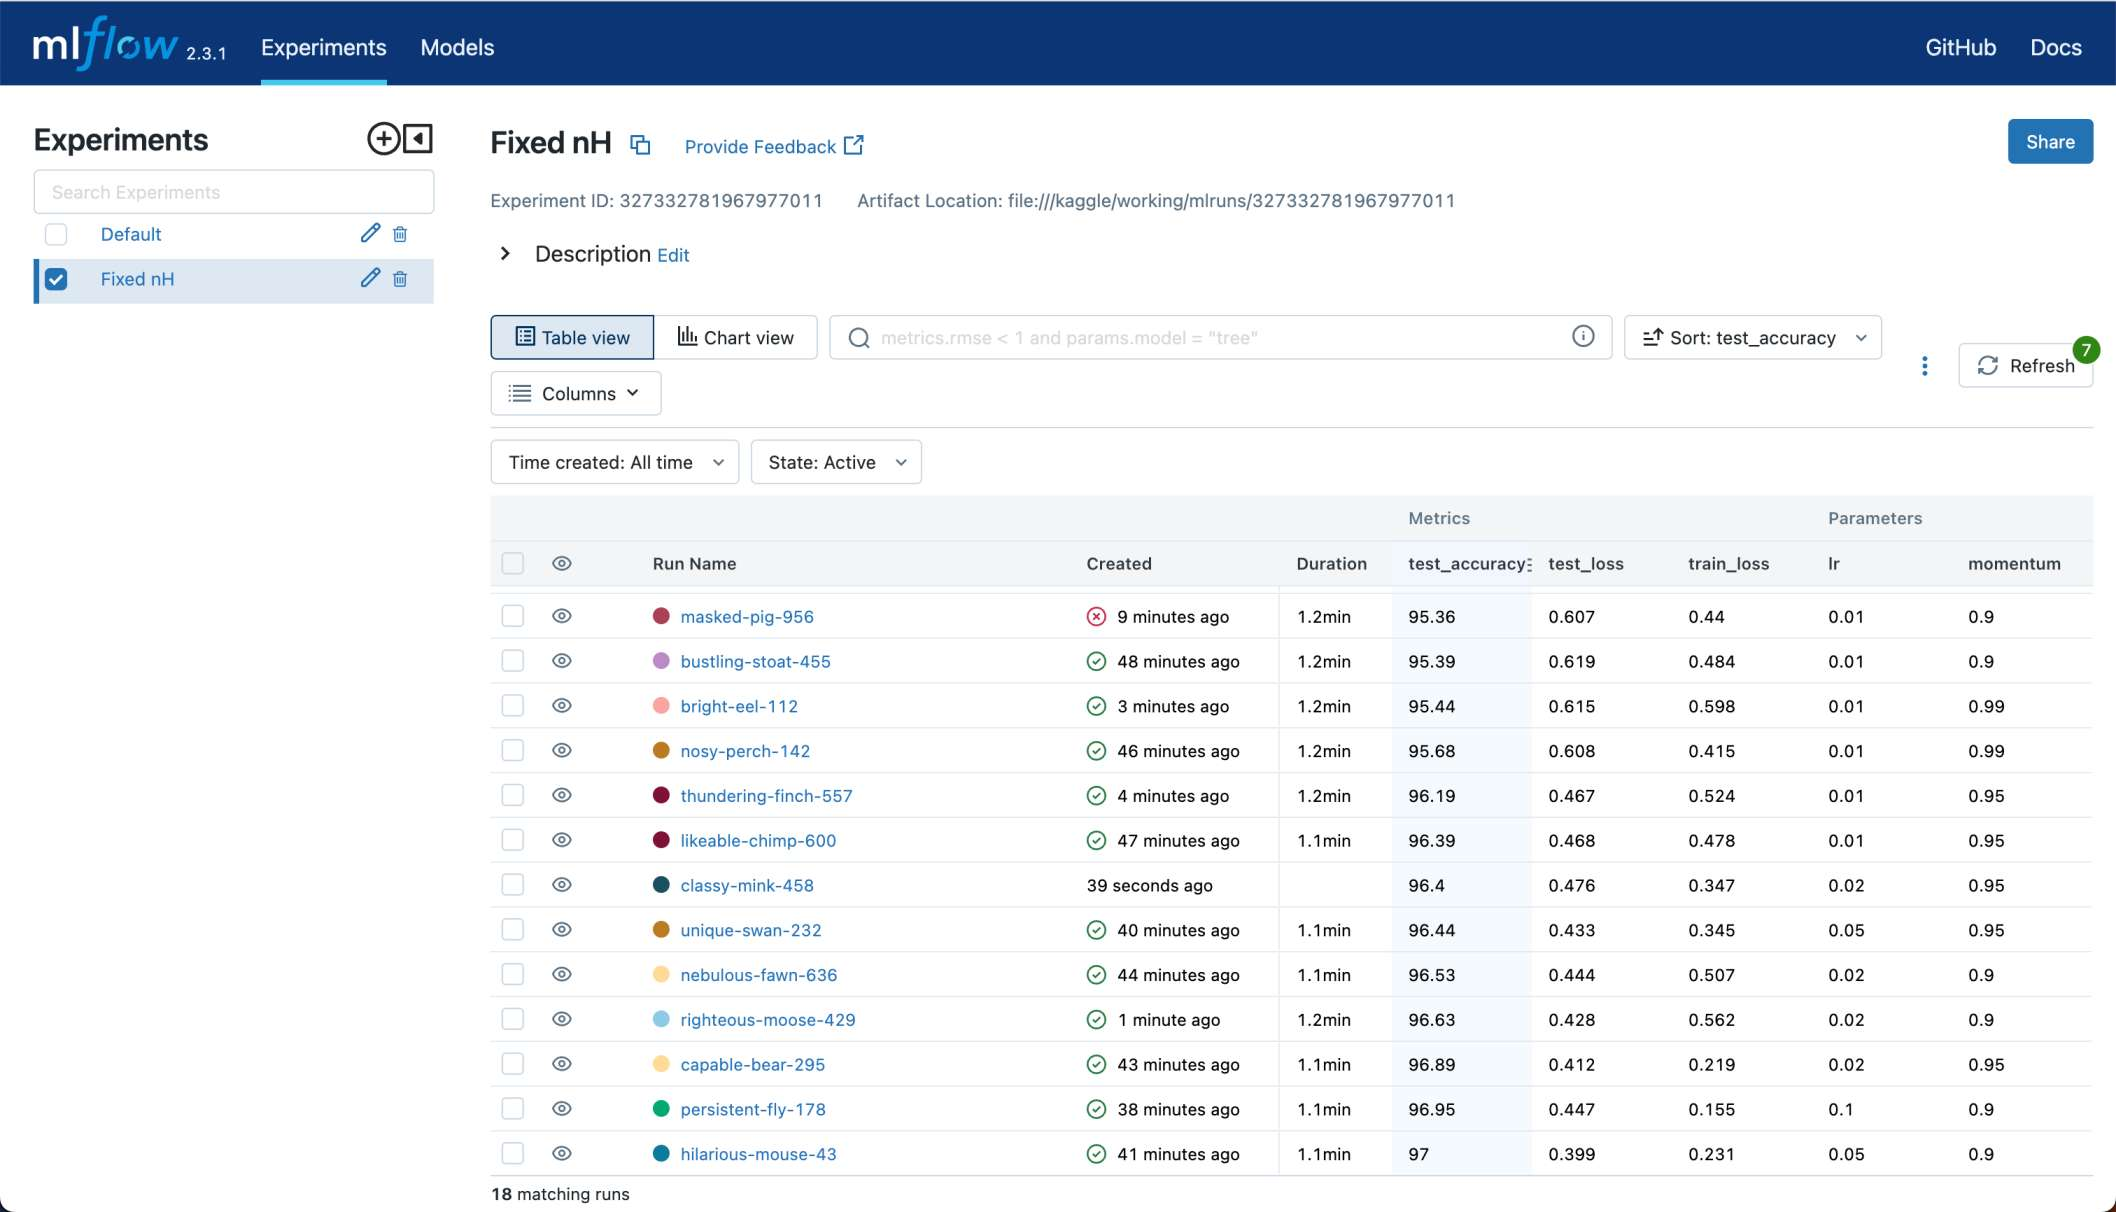

# Params

In [6]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(256, 4, 0, 200)

# Dataset

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('../data', train=True, download=True, 
                         transform=transform)

test_set = datasets.MNIST('../data', train=False, download=True, 
                         transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 134840290.35it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108544528.52it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43794193.17it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19146260.07it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Model

In [8]:
class Model(nn.Module):
    def __init__(self, nH = 32): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
def train(epoch):
    
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))

In [10]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10, 10])
    
    with torch.no_grad():
        
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]
            correct += pred.eq(labels.data).sum().item()
            
            for x, y in zip(pred.numpy(), labels.numpy()):
                confusion_matrix[x][y] += 1
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100.0 * correct / len(test_loader.dataset)
        
        pos = (epoch + 1) * len(train_loader)
        mlflow.log_metric('test_loss', test_loss*1000)
        mlflow.log_metric('test_accuracy', test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset), test_accuracy))
              
        if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                       yticks=np.arange(confusion_matrix.shape[0]),
                       xticklabels=classes, yticklabels=classes,
                       ylabel='True label',
                       xlabel='Predicted label',
                       title='Epoch %d' % epoch)
            thresh = confusion_matrix.max() / 2.
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j, i, int(confusion_matrix[i, j]),
                            ha="center", va="center",
                            color="white" if confusion_matrix[i, j] > thresh else "black")
              
            #fig.tight_layout()
              
            #image_path = '/kaggle/working/images/%s.png' % (expt_id)
            #plt.savefig(image_path)
            #mlflow.log_artifact(image_path)
            

# Hyperparameter tuning loop

2023/05/10 09:08:47 INFO mlflow.tracking.fluent: Experiment with name 'Fixed nH' does not exist. Creating a new experiment.



LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.339

Test set: Average loss: 0.0011, Accuracy: 9186/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.248
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.178

Test set: Average loss: 0.0008, Accuracy: 9384/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.180
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.222

Test set: Average loss: 0.0007, Accuracy: 9483/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.154
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.197


2023/05/10 09:09:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0006, Accuracy: 9557/10000 (96%)



2023/05/10 09:09:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.371
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.354

Test set: Average loss: 0.0009, Accuracy: 9294/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.236
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.120

Test set: Average loss: 0.0006, Accuracy: 9519/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.172
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.089

Test set: Average loss: 0.0005, Accuracy: 9593/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.078
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.169


2023/05/10 09:11:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0004, Accuracy: 9655/10000 (97%)



2023/05/10 09:11:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.321

Test set: Average loss: 0.0014, Accuracy: 9102/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.319
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.144

Test set: Average loss: 0.0010, Accuracy: 9328/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.204
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.132

Test set: Average loss: 0.0008, Accuracy: 9441/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.124
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.206

Test set: Average loss: 0.0007, Accuracy: 9544/10000 (95%)



2023/05/10 09:12:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/10 09:12:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.232

Test set: Average loss: 0.0009, Accuracy: 9338/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.282
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.244

Test set: Average loss: 0.0007, Accuracy: 9481/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.159
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.156

Test set: Average loss: 0.0005, Accuracy: 9612/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.147
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.159


2023/05/10 09:13:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9637/10000 (96%)



2023/05/10 09:13:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.263

Test set: Average loss: 0.0007, Accuracy: 9460/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.144
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.102

Test set: Average loss: 0.0005, Accuracy: 9590/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.153
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.063

Test set: Average loss: 0.0005, Accuracy: 9624/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.092
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.101


2023/05/10 09:14:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0004, Accuracy: 9667/10000 (97%)



2023/05/10 09:14:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.541

Test set: Average loss: 0.0017, Accuracy: 9005/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.404
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.535

Test set: Average loss: 0.0014, Accuracy: 9080/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.352
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.192

Test set: Average loss: 0.0011, Accuracy: 9305/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.105
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.243


2023/05/10 09:15:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0011, Accuracy: 9348/10000 (93%)



2023/05/10 09:15:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.382
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.164

Test set: Average loss: 0.0007, Accuracy: 9490/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.129
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.059

Test set: Average loss: 0.0005, Accuracy: 9626/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.111
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.081

Test set: Average loss: 0.0004, Accuracy: 9662/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.075
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.102


2023/05/10 09:16:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0004, Accuracy: 9704/10000 (97%)



2023/05/10 09:16:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.221

Test set: Average loss: 0.0007, Accuracy: 9484/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.109
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.168

Test set: Average loss: 0.0006, Accuracy: 9548/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.103
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.072

Test set: Average loss: 0.0006, Accuracy: 9577/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.135
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.109


2023/05/10 09:17:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9620/10000 (96%)



2023/05/10 09:17:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.611

Test set: Average loss: 0.0025, Accuracy: 8622/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.527
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.658

Test set: Average loss: 0.0026, Accuracy: 8571/10000 (86%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.712
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.612

Test set: Average loss: 0.0024, Accuracy: 8597/10000 (86%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.422
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.534


2023/05/10 09:18:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0027, Accuracy: 8683/10000 (87%)



2023/05/10 09:19:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.126

Test set: Average loss: 0.0006, Accuracy: 9540/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.115
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.074

Test set: Average loss: 0.0005, Accuracy: 9581/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.072
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.170

Test set: Average loss: 0.0005, Accuracy: 9637/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.075
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.125


2023/05/10 09:20:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9650/10000 (96%)



2023/05/10 09:20:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.370
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.322

Test set: Average loss: 0.0008, Accuracy: 9396/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.174
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.180

Test set: Average loss: 0.0008, Accuracy: 9446/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.227
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.124

Test set: Average loss: 0.0006, Accuracy: 9584/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.148
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.171


2023/05/10 09:21:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0006, Accuracy: 9566/10000 (96%)



2023/05/10 09:21:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.901

Test set: Average loss: 0.0054, Accuracy: 6910/10000 (69%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.076
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.866

Test set: Average loss: 0.0064, Accuracy: 4541/10000 (45%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.489
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.460

Test set: Average loss: 0.0068, Accuracy: 4420/10000 (44%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.407
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.492


2023/05/10 09:22:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0078, Accuracy: 4535/10000 (45%)



2023/05/10 09:22:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


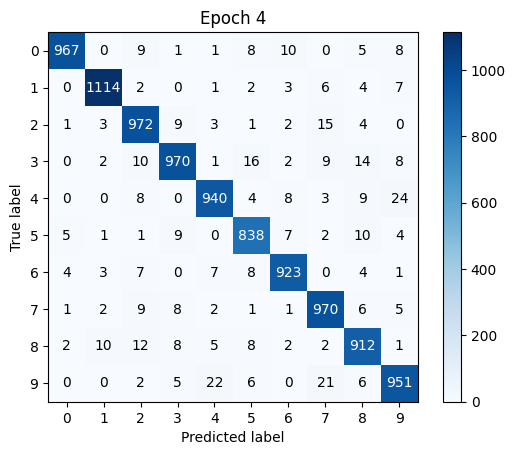

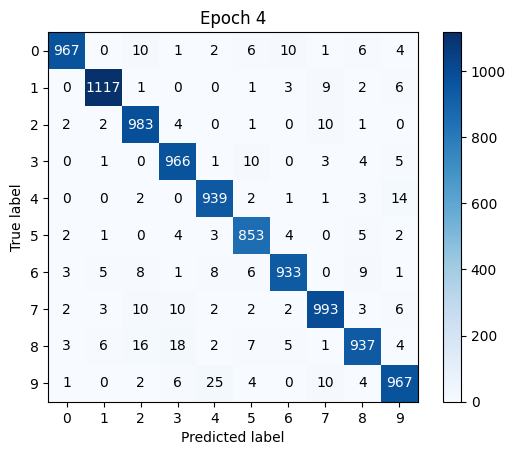

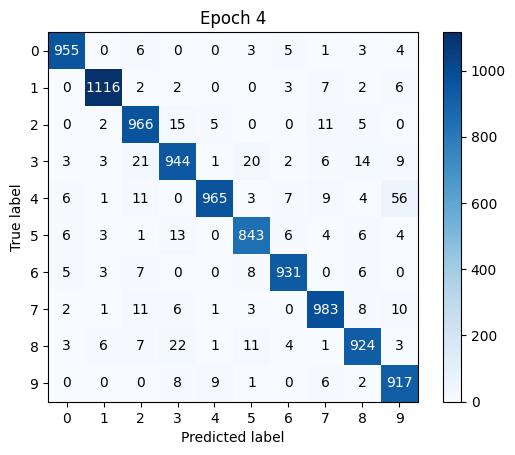

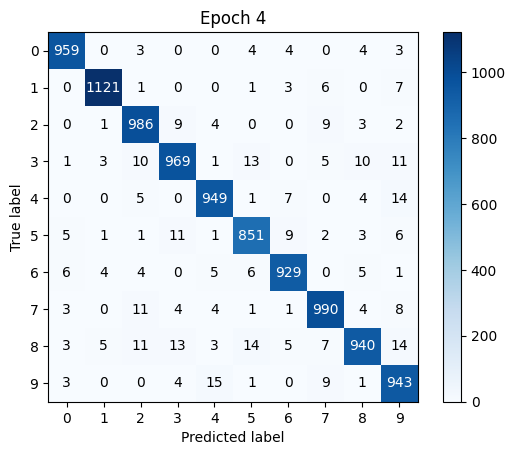

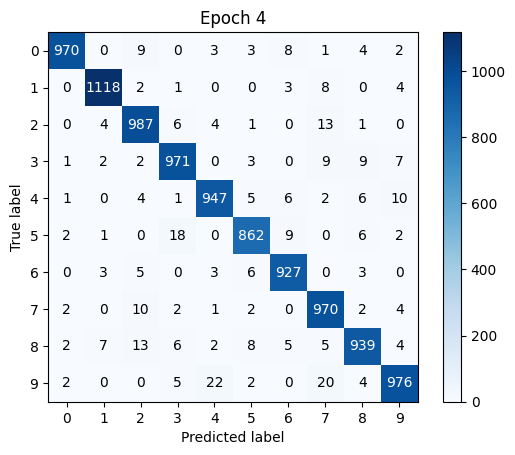

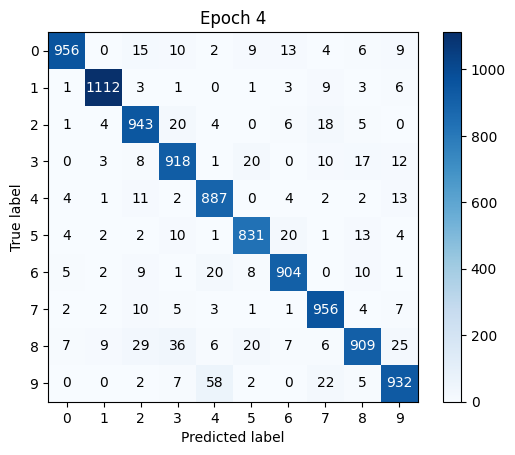

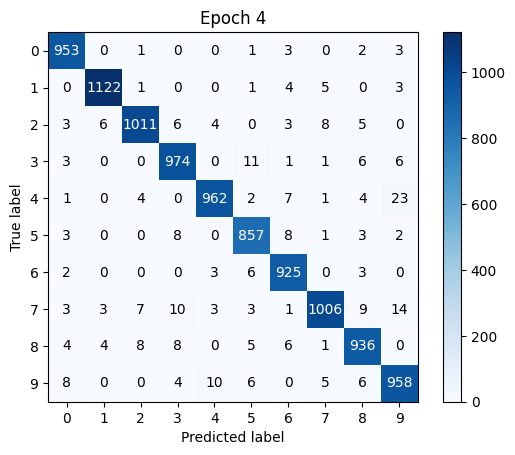

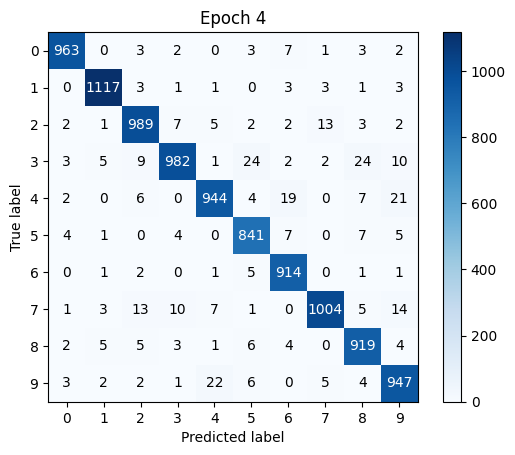

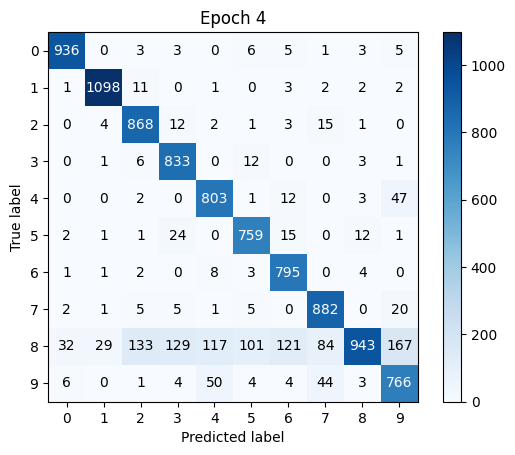

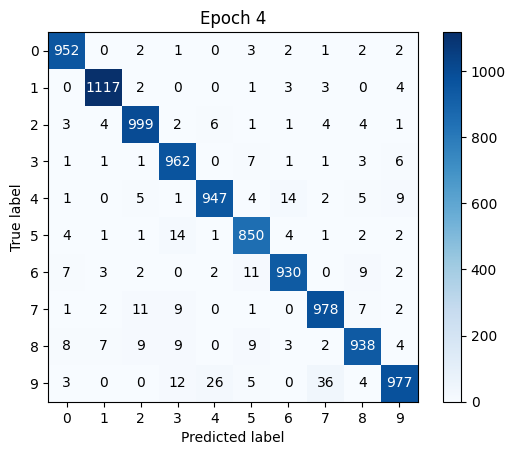

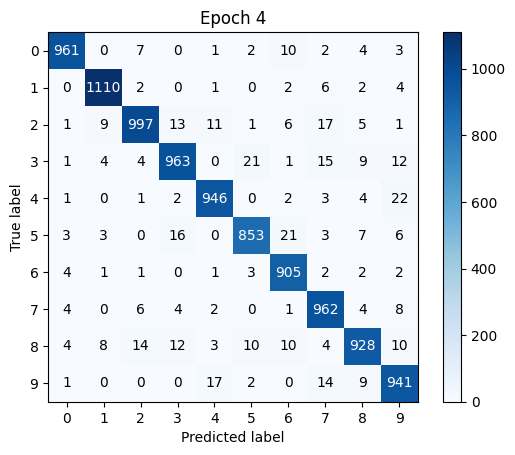

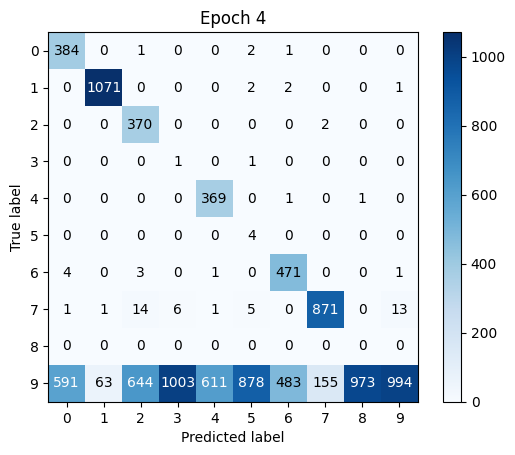

In [11]:
# expt_id = mlflow.create_experiment('Fixed nH')

mlflow.set_experiment('Fixed nH')

for lr in [0.01, 0.02, 0.05, 0.1]:
    for momentum in [0.9, 0.95, 0.99]:
        for hidden_nodes in [48]:
        
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = Model(hidden_nodes)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            with mlflow.start_run() as run:  
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1):
                    train(epoch)
                    test(epoch)

                mlflow.pytorch.log_model(model, "model")

# Loading and visualising a model

In [12]:
# randomly taking a logged model for further analysis. 

import os
dcm =[]
for path, dirs, filename in os.walk("/kaggle/working/mlruns"): 
    for dirname in dirs:
        fullpath = os.path.join(path,dirname)
        if "artifacts" in dirname:
            dcm.append(fullpath)
#print(dcm[0])
model_path = dcm[0]+"/model"
print(model_path)

/kaggle/working/mlruns/612933577482173279/90deb1fb34ce4bf688ef019319cb114d/artifacts/model


In [13]:
model_load = mlflow.pytorch.load_model(model_path)

In [14]:
print(model_load)

Model(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=10, bias=True)
  )
)


In [15]:
weight_layer0 = list(model_load.parameters())[0].data.numpy()
print(weight_layer0.shape)

(48, 784)


[]

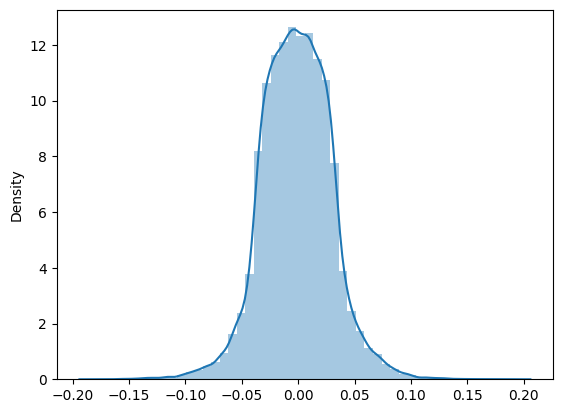

In [16]:
sns.distplot(weight_layer0.ravel())
plt.plot()

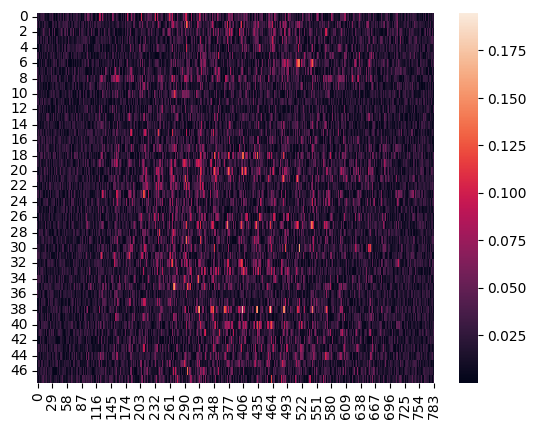

In [17]:
sns.heatmap(np.abs(weight_layer0))
plt.show()

In [18]:
weight_layer1 = list(model_load.parameters())[2].data.numpy()
weight_layer1.shape

(10, 48)

[]

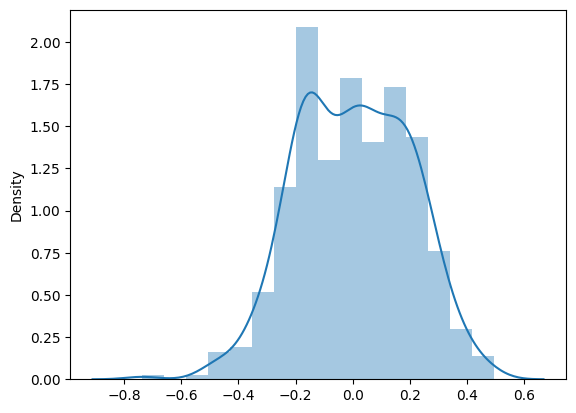

In [19]:
sns.distplot(weight_layer1.ravel())
plt.plot()

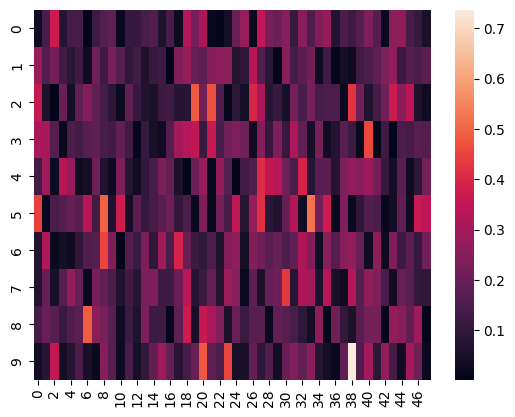

In [20]:
sns.heatmap(np.abs(weight_layer1))
plt.show()

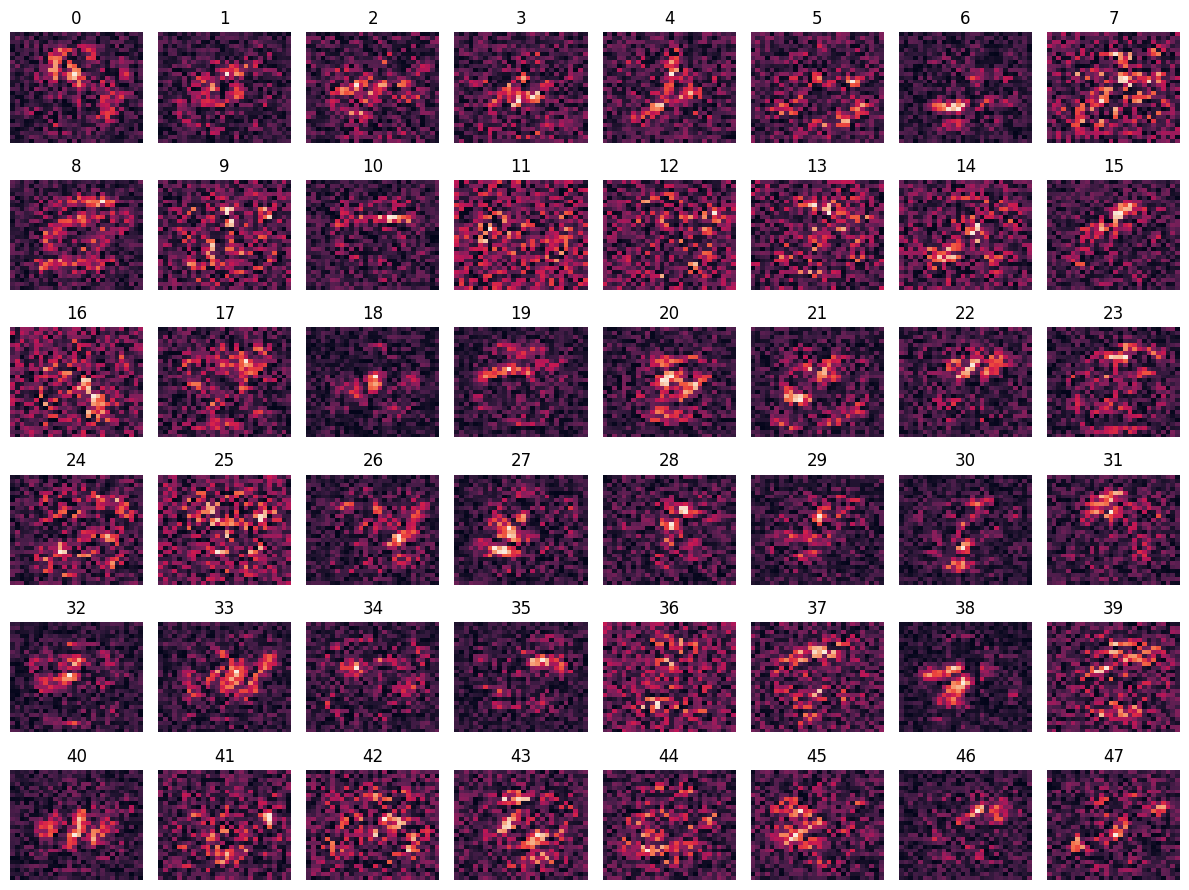

In [21]:
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48): 
    ax1 = fig.add_subplot(nrows, ncols, i+1)
    sns.heatmap(np.abs((weight_layer0[i, 0:784]).reshape(28, 28)), ax = ax1, cbar=False)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title(i)
plt.tight_layout()
plt.show()

# END 